In [34]:
import pandas as pd
import numpy as np
import re
import string
from gensim.models import Word2Vec
from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
import hdbscan 

nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Read Data

In [4]:
datadf = pd.read_csv("data/MenuItem.csv")

In [5]:
datadf

,Restaurant Name,Original food Item
0,Coffee Time,Garden Vegetable Sandwich
1,HoSan,Roasted Seaweed Snack
2,Weight Watchers,Muffins
3,Natural Sea,"Albacore Tuna, Solid White"
4,World of Beer,Caesar Salad with Grilled Flat Iron Steak
...,...,...
4519,Moxie's Classic Grill,Spring Mix Starter Salad
4520,Thundercloud Subs,"Genoa Salami Low-Fat Sub, Large"
4521,Chick-fil-A,"Cookies & Cream Milkshake, Small"
4522,Cereality,2% Milk


# Data exploration

In [6]:
len(datadf['Restaurant Name'].unique())

341

In [7]:
datadf.isnull().sum().sum()

0


### Summary
*  341 unique restaurants
*  Dataset contains no null values.





# Preprocessing

In [8]:
def clean_text(text, tokenizer, stopwords):
    """Pre-process text and generate tokens

    Args:
        text: Text to tokenize.

    Returns:
        Tokenized text.
    """
    text = str(text).lower()  # Lowercase words
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", "", text
    )  # Remove punctuation

    tokens = tokenizer(text)  # Get tokens from text
    tokens = [t for t in tokens if not t in stopwords]  # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens]  # Remove digits
    tokens = [t for t in tokens if len(t) > 1]  # Remove short tokens
    return tokens

In [9]:
custom_stopwords = set(stopwords.words("english") + [])

datadf["Original food Item"] = datadf["Original food Item"].map(lambda x: clean_text(x, word_tokenize, custom_stopwords))


In [10]:
datadfc = datadf.groupby('Restaurant Name')["Original food Item"].apply(lambda x: list(x))

In [11]:
datadfcombined = datadf.groupby('Restaurant Name').agg({"Original food Item": 'sum'}).reset_index()
datadfcombined["Original food Item"] = datadfcombined["Original food Item"].map(lambda x: np.unique(x))
datadfcombined["Original food Item"] = datadfcombined["Original food Item"].map(lambda x: ' '.join(x))

In [12]:
datadfcombined

,Restaurant Name,Original food Item
0,241 Pizza,bacon based basil bbq bread buffalo canadian c...
1,A&W (Canada),apple aw bacon beer beyond blt bonein breakfas...
2,Amay's,almond cookies
3,Ameci Pizza & Pasta,alfredo ameci antipasto ball bread caesar calz...
4,America's Taco Shop,al asada bean beans bread burrito carne cevich...
...,...,...
336,Yellow Tail,grigio moscato pinot
337,YoCream,acai almondmilk batter bean berry blueberry br...
338,Yogli Mogli,acai angel batter berry blackberry blueberry b...
339,Yoshinoya,asian bbq beef bowl brisk brown butter cake ca...



### Preprocessing Summary
*  All words are changed to lowercase.
*  Removed all characters/punctuations and digits.
*  Removed all stop words.
*  Combined the restaurant's menu into a single string, producing 341 rows.

# Embeddings

## Experiment 1: Using sentence similarity pretrained models 

In [ ]:
# model = SentenceTransformer('distilbert-base-uncased')
# model = SentenceTransformer('distilbert-base-nli-mean-tokens')
# model = SentenceTransformer('edwardjross/xlm-roberta-base-finetuned-recipe-all')
model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
embeddings = model.encode( datadfcombined["Doc"], show_progress_bar=True)

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

## Experiment 2: By using fasttext 

In [14]:
import fasttext
model = fasttext.train_supervised('train.txt', lr=0.01, epoch=500, wordNgrams=3)

In [15]:
fembeddings = []
for index, row in datadfcombined.iterrows():
  fembeddings.append(model.get_sentence_vector(row['Original food Item']))

## Visualize Embeddings

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


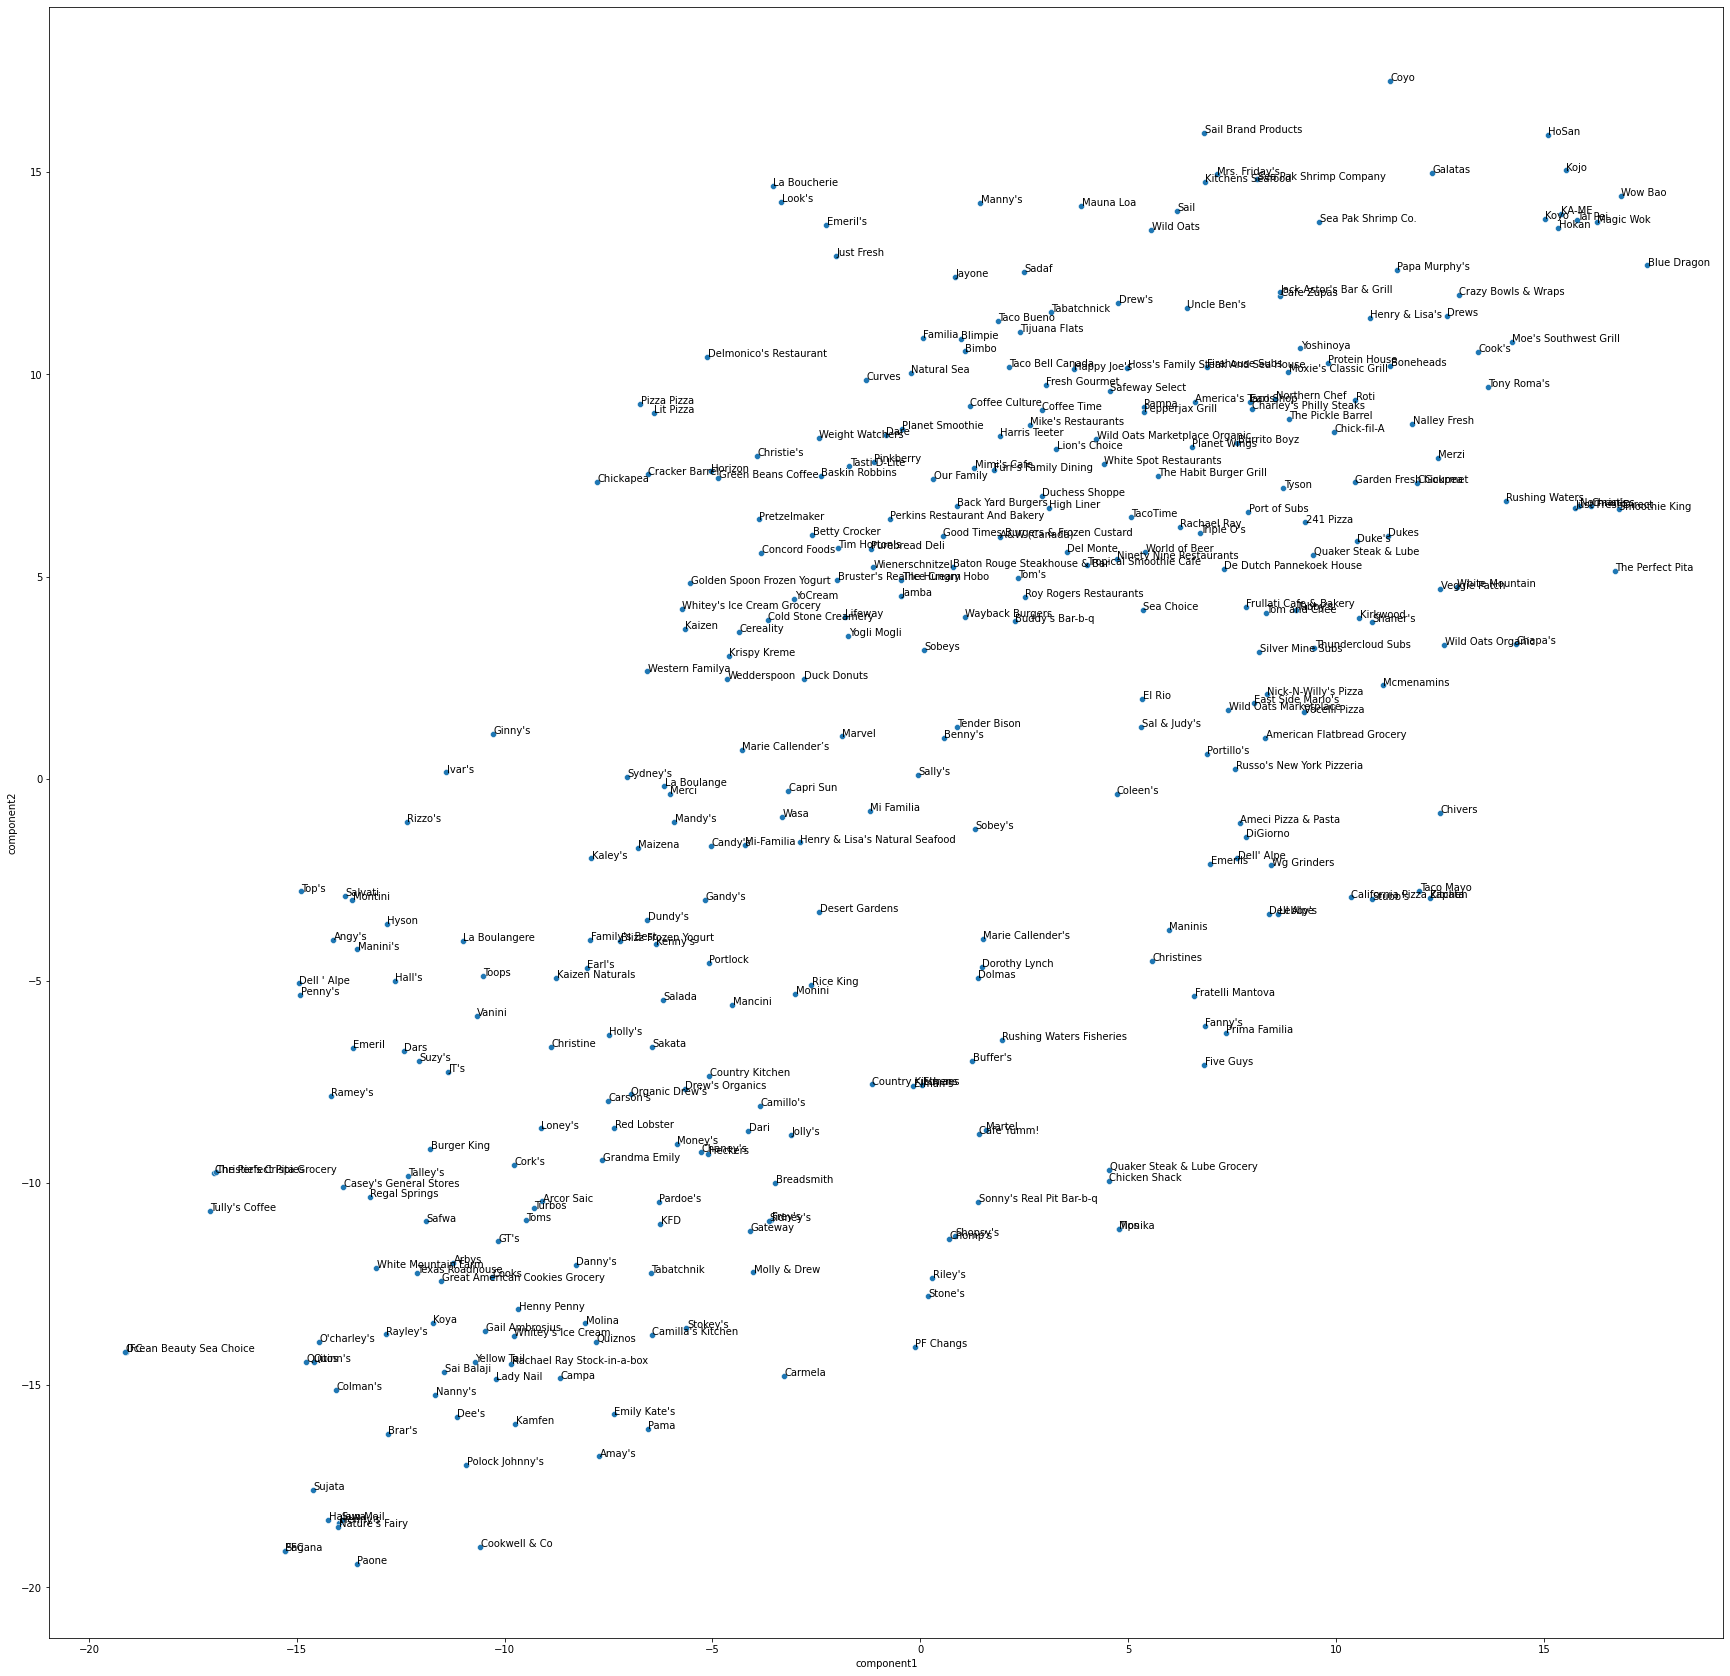

In [16]:
tsne = TSNE(n_components=2)
fig = plt.figure(figsize=(30,30))
tsne_components = tsne.fit_transform(fembeddings)

restaurant_df = pd.DataFrame()
restaurant_df['component1'] = tsne_components[:,0]
restaurant_df['component2'] = tsne_components[:,1]
restaurant_df['restaurant_name'] = datadfcombined['Restaurant Name']
scatter_plt = sns.scatterplot(data=restaurant_df,x='component1',y='component2')

for indx in range(0,len(restaurant_df)):
     scatter_plt.text(restaurant_df['component1'][indx]+0.01,restaurant_df['component2'][indx], restaurant_df['restaurant_name'][indx])


### Embeddings Summary

Experiment 1: Using sentence similarity pretrained models 
*  Used a pretrained sentence similarity model like all-MiniLM-L6-v2 to build embeddings that are close to each other for food menus that are similar to each other.



Experiment 2: Using fasttext
*  I trained a fasttext model using a dataset from Kaggle that included dishes/menus and the cuisine they belong to.
*  And utilized this model to generate embeddings for the dataset provided for this project.
* Similarly, the fasttext model can be trained for cuisine, ingredient used, or dish type or any other context depending on the clustering requirements. 

Result: Clusters in experiment2 made more sense


Kaggle dataset sample
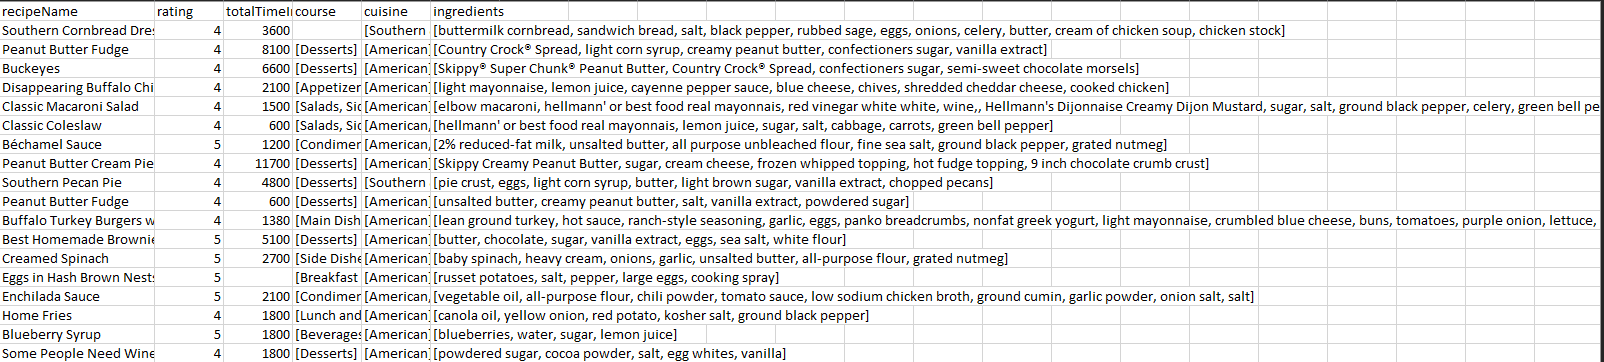


# Clustering

## Finding optimal K(number of clusters) using silhouette analysis

In [50]:
silhouette_avg = []
range_clusters = range(2,50)
for num_clusters in range_clusters:
 
 # initialise kmeans
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(fembeddings)
 cluster_labels = kmeans.labels_
 
 # silhouette score
 silhouette_avg.append(silhouette_score(fembeddings, cluster_labels))

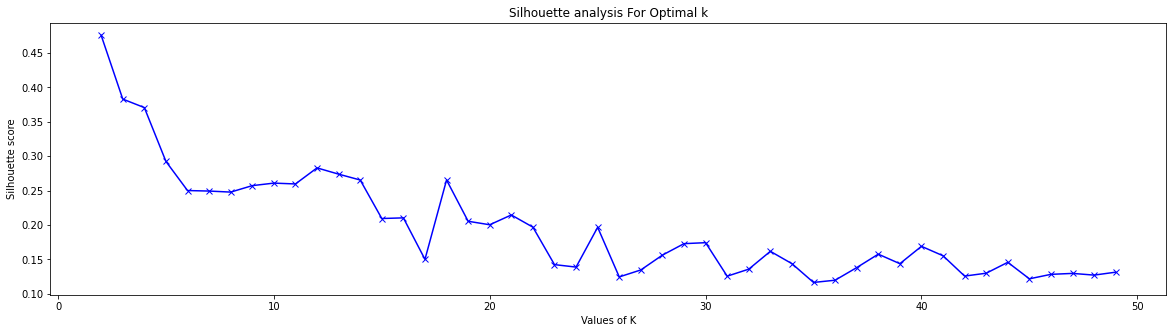

2


In [51]:
plt.figure(figsize=(20,5))
plt.plot(range_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()
best_num_cluster = range_clusters[silhouette_avg.index(np.max(silhouette_avg))]
print(best_num_cluster)

 
Summary
*   K-Means and silhouette analysis were used to get an idea of the ideal number of clusters.
*   The figure above illustrates that number of clusters should be between 10 and 14.


## Dimensionality Reduction and Clustering

In [36]:
umap_embeddings  = umap.UMAP(n_neighbors=5, n_components=5, metric='cosine').fit_transform(fembeddings)

In [38]:
hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=10,
                          min_samples = 2,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

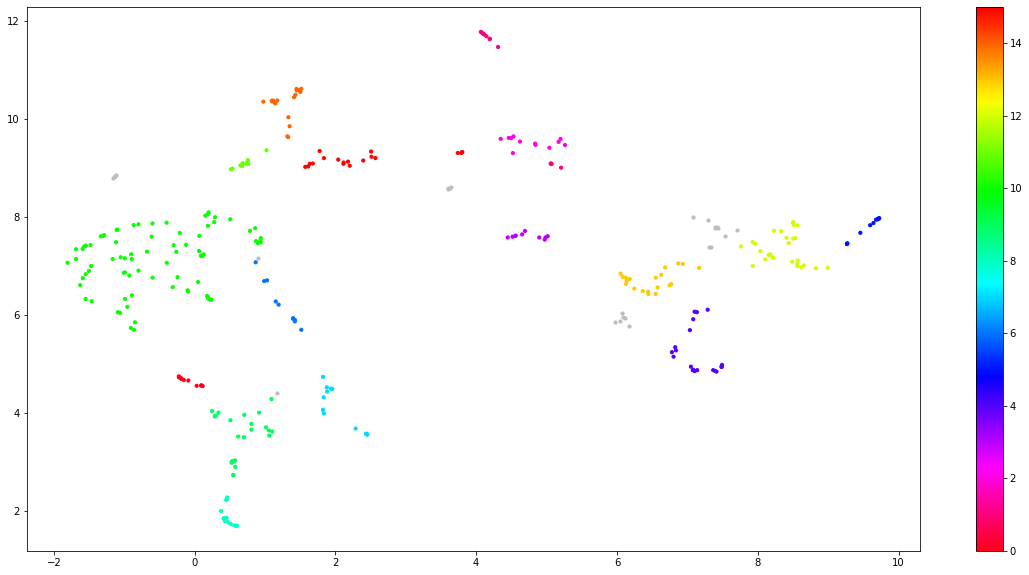

In [40]:
umap_menu_items_embeddings = umap.UMAP(n_neighbors=5, n_components=2, min_dist=0.0, metric='cosine').fit_transform(fembeddings)
result = pd.DataFrame(umap_menu_items_embeddings, columns=['x', 'y'])
result['labels'] = hdbscan_cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=10)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=10, cmap='hsv_r')
plt.colorbar()


### Clustering Summary
*  Used umap for dimensionality reduction 
*  Used HDBSCAN clustering method to generated clusters from the embeddings.


# Evaluating the clusters

## Using Topic Modeling

In [41]:
datadfcombined= datadfcombined.rename(columns={'Original food Item': 'Doc'})
docs_df = pd.DataFrame(datadfcombined, columns=["Doc"])
docs_df['Topic'] = hdbscan_cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))

In [42]:
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [43]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(datadfcombined))

In [44]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

In [45]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
11,10,78
13,12,28
0,-1,27
10,9,25
14,13,21
5,4,20
16,15,19
15,14,18
8,7,14
9,8,13


In [47]:
datadfcombined['Topic'] = hdbscan_cluster.labels_

### Top words in every cluster

In [48]:
for topic in topic_sizes['Topic']:
  print(topic)
  print(top_n_words[topic][:20])
  print()

10
[('chicken', 0.01789272104539569), ('salad', 0.016588491243286096), ('bbq', 0.016497473722127766), ('sauce', 0.01625468011177681), ('grilled', 0.014920580176995291), ('steak', 0.014323791970255273), ('cheese', 0.013879615353939705), ('dressing', 0.01353380022092518), ('bacon', 0.013456611212712272), ('ranch', 0.012962300781671817), ('bowl', 0.012885955607405021), ('hot', 0.012154775623246359), ('sandwich', 0.012066351728948514), ('roasted', 0.012048573092187778), ('rice', 0.011919308933663463), ('beef', 0.011774736738633199), ('honey', 0.01163574963349912), ('potato', 0.011181275676254664), ('fries', 0.011025354505921256), ('sweet', 0.010989407030582765)]

12
[('pie', 0.0653669048752745), ('grigio', 0.06479869419203908), ('crispn', 0.06479869419203908), ('arepas', 0.06479869419203908), ('cornic', 0.06479869419203908), ('moscato', 0.06479869419203908), ('shepherds', 0.06479869419203908), ('tocino', 0.06479869419203908), ('blistered', 0.06479869419203908), ('nectar', 0.064798694192039

In [49]:
for topic in topic_sizes['Topic']:
  print(topic)
  print(datadfcombined.query("Topic == @topic"))
  print()

10
                   Restaurant Name  \
0                        241 Pizza   
4              America's Taco Shop   
11    Baton Rouge Steakhouse & Bar   
18                       Boneheads   
25                    Burrito Boyz   
..                             ...   
326         White Spot Restaurants   
332  Wild Oats Marketplace Organic   
334                  World of Beer   
339                      Yoshinoya   
340                         Zapata   

                                                   Doc  Topic  
0    bacon based basil bbq bread buffalo canadian c...     10  
4    al asada bean beans bread burrito carne cevich...     10  
11   amarillo apple apples artichoke atlantic back ...     10  
18   asian blue boneheads boneless breast caesar ca...     10  
25   battered breaded breast burrito calamari chees...     10  
..                                                 ...    ...  
326  add alfredo artichoke avocado baby back bacon ...     10  
332  apples bars basil cerea

### Evaluating the clusters Summary
*  Since the embedding model was trained on a dataset of cuisines, clusters of restaurants with related cuisines were formed.
*  Used topic modeling technique to identify the type of cluster.
*  TF-IDF is used to get most frequent words.

Possible cluters 
*  The top words in Topic 0 are "sandwich","shake" and "tea" which suggests that it can be a cluster of burger and cafes.
*  The top words in Topic 1 are "teriyaki","noodles" and "soba," which suggests that it can be a cluster of Japanese restaurants.
*  The top words in Topic 3 are "salmon" and "fillet" which suggests that it can be a cluster sea food restaurant
*  The top words in Topic 8 are "chocolate","cheesecakes' and "cookie" which suggests that it can be a cluster of dessert restaurants
*  The top words in Topic 8 are "chocolate","cheesecakes' and "cookie" which suggests that it can be a cluster of dessert restaurants
*  The top words in Topic 11 are "pasta","garlic' and "pesto" which suggests that it can be a cluster of italian restaurant
*  The top words in Topic 13 are "granola","almond' and "cranberry" which suggests that it can be a cluster of cereals and juice bar
